### **Mengimpor _Library_ Yang Dibutuhkan**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### **Mengumpulkan Data**
**Dataset** : [Bike Sharing Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset)

**Files** :
- **Readme.txt**
- **hour.csv** : bike sharing counts aggregated on hourly basis. Records: 17379 hours
- **day.csv** : bike sharing counts aggregated on daily basis. Records: 731 days

In [2]:
hour_df = pd.read_csv("hour.csv")

day_df = pd.read_csv("day.csv")

In [3]:
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### **Menilai Kualitas Data**

In [5]:
#Menilai Data hour_df
hour_df.info()
print(f"Missing values: {hour_df.isna().sum()}")
print(f"Jumlah duplikasi: {hour_df.duplicated().sum()}")
hour_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
Missing values: instant       0
dteday        0
s

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


**Tidak ada _missing values_ dan _duplicates_, tetapi tipe data pada kolom _dteday_ seharusnya _datetime_**

In [6]:
#Menilai Data day_df
day_df.info()
print(f"Missing values: {day_df.isna().sum()}")
print(f"Jumlah duplikasi: {day_df.duplicated().sum()}")
day_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
Missing values: instant       0
dteday        0
season        0
yr            0
mnth         

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


**Tidak ada _missing values_ dan _duplicates_, tetapi tipe data pada kolom _dteday_ seharusnya _datetime_**

### **Membersihkan Data**

**Mengubah tipe data di kolom dteday dari _object_ menjadi _datetime_**

In [7]:
day_df['dteday'] = pd.to_datetime(day_df['dteday']) 
# Memastikan perubahan berhasil
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), floa

In [8]:
hour_df['dteday'] = pd.to_datetime(hour_df['dteday']) 
# Memastikan perubahan berhasil
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

### **Pertanyaan Bisnis**

1. Bagaimana mengidentifikasi pola penggunaan sepeda berdasarkan waktu (jam) dalam sehari menggunakan clustering untuk mengoptimalkan ketersediaan sepeda?
2. Bagaimana pola penggunaan sepeda berbeda antara hari kerja dan akhir pekan menggunakan analisis RFM sederhana?

### **Eksplorasi Data**

- Mengganti nilai pada kolom season dari 1 - 4 menjadi musim semi, musim panas, musim gugur, musim dingin

In [9]:
# Menggunakan replace untuk mengganti nilai
# Menggunakan def untuk tidak menuliskan dua kali
def replace_season(df):
    df["season"] = df["season"].replace({
        1: "Musim Semi", 
        2: "Musim Panas", 
        3: "Musim Gugur", 
        4: "Musim Dingin"
    })
    return df

hour_df = replace_season(hour_df)
day_df = replace_season(day_df)

- Mengganti nilai pada kolom yr dari 0 dan 1 menjadi 2011 dan 2012

In [10]:
# Menggunakan replace untuk mengganti nilai
def replace_year(df):
    df["yr"] = df["yr"].replace({
        0: 2011,
        1: 2012
    })
    return df

hour_df = replace_year(hour_df)
day_df = replace_year(day_df)

- Mengganti nilai pada kolom mnth dari 1 sampai 12 menjadi Januari sampai Desember

In [11]:
# Menggunakan replace untuk mengganti nilai
def replace_month(df):
  df["mnth"] = df ["mnth"].replace({
    1: "Januari",
    2: "Februari",
    3: "Maret",
    4: "April",
    5: "Mei",
    6: "Juni",
    7: "Juli",
    8: "Agustus",
    9: "September",
    10: "Oktober",
    11: "November",
    12: "Desember"
  })
  
hour_df = replace_month(hour_df)
day_df = replace_month(day_df)

- Mengganti nilai pada kolom holiday dari 0 dan 1 menjadi liburan dan tidak liburan

In [12]:
hour_df = pd.DataFrame({
    "holiday" : [0, 1]
})

day_df = pd.DataFrame({
    "holiday" : [0, 1]
})


# Menggunakan replace untuk mengganti nilai
def replace_holiday(df):
    df["holiday"] = df["holiday"].replace({
        0: "Liburan",
        1: "Tidak Liburan"
    })
    return df

hour_df = replace_holiday(hour_df)
day_df = replace_holiday(day_df)

- Mengganti nilai pada kolom weekday dari 0 sampai 6 menjadi Senin, Selasa, Rabu, Kamis, Jumat, Sabtu, Minggu

In [13]:
hour_df = pd.DataFrame({
    "weekday" : [0, 1, 2, 3, 4, 5, 6]
})

day_df = pd.DataFrame({
    "weekday" : [0, 1, 2, 3, 4, 5, 6]
})

# Menggunakan replace untuk mengganti nilai
def replace_weekday(df):
    df["weekday"] = df["weekday"].replace({
        0: "Senin",
        1: "Selasa",
        2: "Rabu",
        3: "Kamis",
        4: "Jumat",
        5: "Sabtu",
        6: "Minggu"
    })
    return df

hour_df = replace_weekday(hour_df)
day_df = replace_weekday(day_df)

- Mengganti nilai pada kolom workingday dari 1 dan 0 menjadi hari kerja dan akhir pekan

In [14]:
hour_df = pd.DataFrame({
    "workingday" : [0, 1]
})

day_df = pd.DataFrame({
    "workingday" : [0, 1]
})

# Menggunakan replace untuk mengganti nilai
def replace_workingday(df):
    df["workingday"] = df["workingday"].replace({
        0: "Akhir Pekan",
        1: "Hari Kerja"
    })
    return df

hour_df = replace_workingday(hour_df)
day_df = replace_workingday(day_df)

- Mengganti nilai pada kolom weathersit dari 1 sampai 4 menjadi cerah sampai hujan lebat

In [15]:
hour_df = pd.DataFrame({
    "weathersit" : [1, 2, 3, 4]
})

day_df = pd.DataFrame({
    "weathersit" : [1, 2, 3, 4]
})

# Menggunakan replace untuk mengganti nilai
def replace_weathersit(df):
    df["weathersit"] = df["weathersit"].replace({
        1: "Cerah atau Sedikit Awan",
        2: "Kabut dan Berawan",
        3: "Hujan Ringan dan Badai Petir atau Salju Ringan",
        4: "Hujan Lebat dan Badai Petir atau Salju"
    })
    return df

hour_df = replace_weathersit(hour_df)
day_df = replace_weathersit(day_df)

### **Visualisasi Data**

1. Bagaimana mengidentifikasi pola penggunaan sepeda berdasarkan waktu (jam) dalam sehari menggunakan clustering untuk mengoptimalkan ketersediaan sepeda?

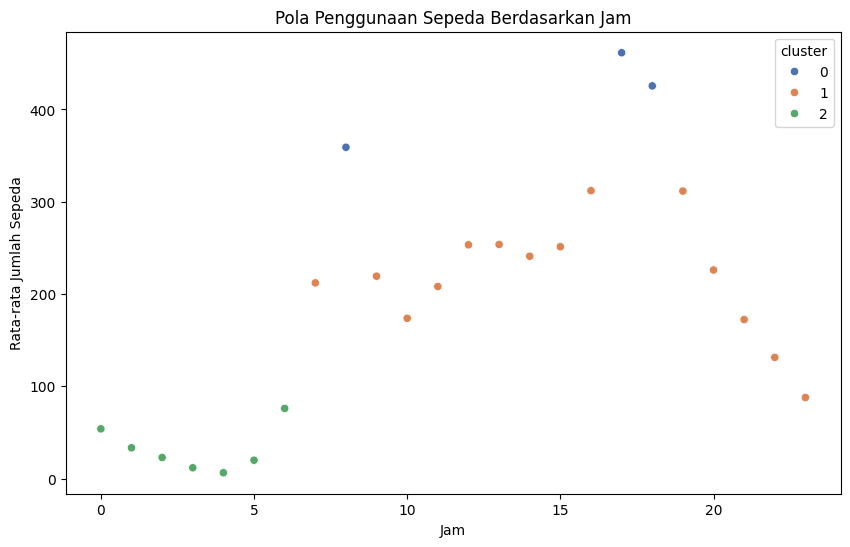


Karakteristik Cluster:

Cluster 0:
Jam: [8, 17, 18]
Rata-rata penggunaan: 415.32

Cluster 1:
Jam: [7, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23]
Rata-rata penggunaan: 218.10

Cluster 2:
Jam: [0, 1, 2, 3, 4, 5, 6]
Rata-rata penggunaan: 32.02


In [16]:
# Menyimpan dataset "hour.csv" dalam variabel df
df = pd.read_csv('hour.csv')

# Mengelompokkan data berdasarkan kolom "hr" dan dihitung rata-rata jumlah pengguna sepeda untuk setiap jam
data_cluster = df.groupby('hr')[['cnt']].mean().reset_index()

# Normalisasi data dengan StandardScaler untuk mengubah skala variabel sehingga memiliki mean 0 dan sd 1
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)

# Melakukan clustering dengan KMeans (misalnya dengan 3 cluster)
kmeans = KMeans(n_clusters=3, random_state=42)
data_cluster['cluster'] = kmeans.fit_predict(data_scaled)

# Visualisasi hasil dengan scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_cluster, x='hr', y='cnt', hue='cluster', palette='deep')
plt.title('Pola Penggunaan Sepeda Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Rata-rata Jumlah Sepeda')
plt.show()

# Analisis karakteristik setiap cluster 
print("\nKarakteristik Cluster:")
for cluster in range(3):
    cluster_data = data_cluster[data_cluster['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Jam: {cluster_data['hr'].tolist()}")
    print(f"Rata-rata penggunaan: {cluster_data['cnt'].mean():.2f}")

2. Bagaimana pola penggunaan sepeda berbeda antara hari kerja dan akhir pekan menggunakan analisis RFM sederhana?

C:\Users\arbaz\AppData\Local\Temp\ipykernel_14820\1881510732.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m_work, m_weekend], labels=['Hari Kerja', 'Akhir Pekan'])


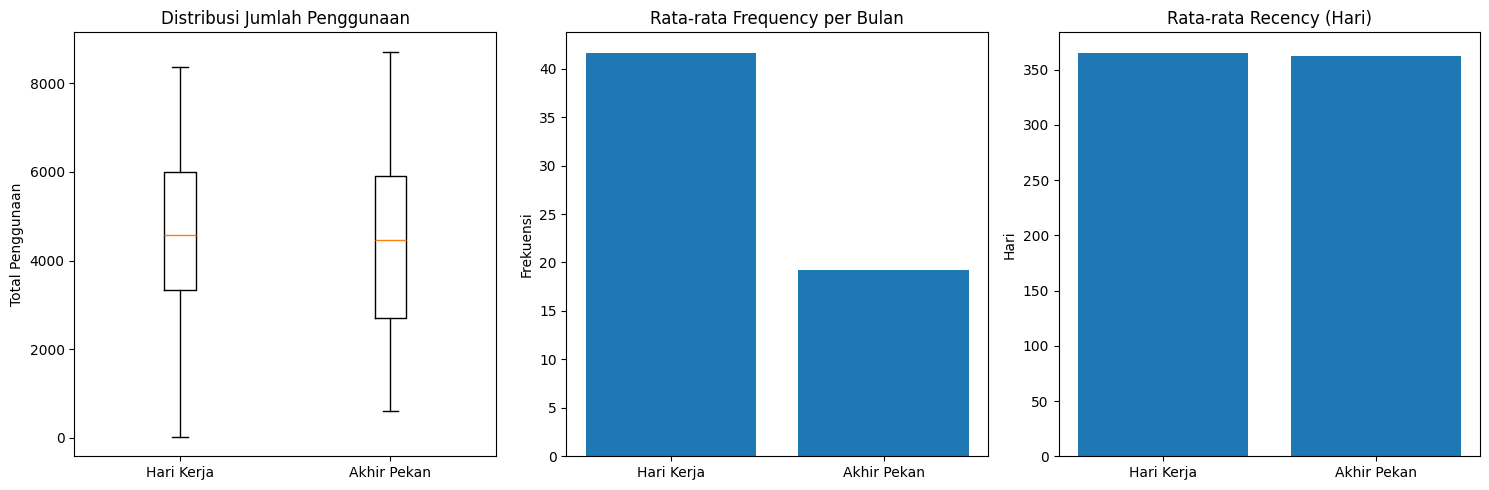


Ringkasan Statistik:

Hari Kerja:
Rata-rata penggunaan: 4584.82
Rata-rata frequency per bulan: 41.67
Rata-rata recency: 365.62 hari

Akhir Pekan:
Rata-rata penggunaan: 4330.17
Rata-rata frequency per bulan: 19.25
Rata-rata recency: 362.65 hari


In [17]:
# Menyimpan dataset "day.csv" dalam variabel df
df = pd.read_csv('day.csv')

# Menghitung metrik RFM sederhana
def calculate_rfm(data, is_workday):
    # Filter hari kerja atau akhir pekan berdasarkan kolom "workingday"
    subset = data[data['workingday'] == is_workday]
    
    # Recency: jumlah  hari sejak hari terakhir penggunaan sepeda hingga akhir data
    max_date = pd.to_datetime(subset['dteday']).max()
    recency = (max_date - pd.to_datetime(subset['dteday'])).dt.days
    
    # Frequency: jumlah hari penggunaan sepeda per bulan
    frequency = subset.groupby(pd.to_datetime(subset['dteday']).dt.month)['cnt'].count()
    
    # Monetary: jumlah penggunaan sepeda
    monetary = subset['cnt']
    
    return recency, frequency, monetary

# Menghitung RFM untuk hari kerja dan akhir pekan
r_work, f_work, m_work = calculate_rfm(df, 1)  # hari kerja
r_weekend, f_weekend, m_weekend = calculate_rfm(df, 0)  # akhir pekan

# Visualisasi perbandingan dengan ukuran 15x5 untuk visualisasi perbandingan
plt.figure(figsize=(15, 5))

# Monetary : membandingkan distribusi jumlah penggunaan sepeda hari kerja dengan akhir pekan dengan plot box plot
plt.subplot(1, 3, 1)
plt.boxplot([m_work, m_weekend], labels=['Hari Kerja', 'Akhir Pekan'])
plt.title('Distribusi Jumlah Penggunaan')
plt.ylabel('Total Penggunaan')

# Frequency : menampilkan rata-rata frekuensi penggunaan sepeda per bulan hari kerja dengan akhir pekan dengan bar plot
plt.subplot(1, 3, 2)
plt.bar(['Hari Kerja', 'Akhir Pekan'], 
        [f_work.mean(), f_weekend.mean()])
plt.title('Rata-rata Frequency per Bulan')
plt.ylabel('Frekuensi')

# Recency : menampilkan rata-rata recency (dalam hari) antara hari kerja dan akhir pekan dengan bar plot
plt.subplot(1, 3, 3)
plt.bar(['Hari Kerja', 'Akhir Pekan'], 
        [r_work.mean(), r_weekend.mean()])
plt.title('Rata-rata Recency (Hari)')
plt.ylabel('Hari')

plt.tight_layout()         # Supaya tampilan plot lebih rapi
plt.show()                 # Menampilkan plot

# Print ringkasan statistik untuk hari kerja dan akhir pekan
print("\nRingkasan Statistik:")
print("\nHari Kerja:")
print(f"Rata-rata penggunaan: {m_work.mean():.2f}")
print(f"Rata-rata frequency per bulan: {f_work.mean():.2f}")
print(f"Rata-rata recency: {r_work.mean():.2f} hari")

print("\nAkhir Pekan:")
print(f"Rata-rata penggunaan: {m_weekend.mean():.2f}")
print(f"Rata-rata frequency per bulan: {f_weekend.mean():.2f}")
print(f"Rata-rata recency: {r_weekend.mean():.2f} hari")

### **Menyimpan berkas data yang telah dianalisis**

In [18]:
# Menyimpan dataset "hour.csv" dalam variabel df
df = pd.read_csv('hour.csv')

# 1. Analisis Clustering berdasarkan waktu
def create_clustering_results():
    # Menghitung rata-rata penggunaan per jam
    hourly_pattern = df.groupby('hr')[['cnt']].mean().reset_index()
    
    # Clustering
    scaler = StandardScaler()                                          # Normalisasi kolom "cnt" pada "hourly_pattern"
    data_scaled = scaler.fit_transform(hourly_pattern)
    kmeans = KMeans(n_clusters=3, random_state=42)                     # Melakukan clustering dengan 3 cluster
    hourly_pattern['cluster'] = kmeans.fit_predict(data_scaled)
    
    return hourly_pattern                                              # Mengembalikan hasil clustering

# 2. Analisis RFM untuk hari kerja vs weekend
def create_rfm_results():
    # Membuat analisis RFM berdasarkan "workingday" dan "dteday"
    workday_analysis = df.groupby(['dteday', 'workingday']).agg({
        'cnt': 'sum',
        'casual': 'sum',
        'registered': 'sum'
    }).reset_index()
    
    return workday_analysis                                           # Mengembalikan hasil akumulasi RFM per tanggal dan kategori hari kerja

clustering_results = create_clustering_results()                      # Memanggil hasil analisis clustering dan disimpan dalam variavel clustering_results
rfm_results = create_rfm_results()                                    # Memanggil hasil analisis RFM dan disimpan dalam variabel rfm_results

# Menyimpan hasil analisis ke CSV
clustering_results.to_csv('clustering_results.csv', index=False)
rfm_results.to_csv('rfm_results.csv', index=False)